# Import


In [5]:
import numpy as np
import pandas as pd
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import matplotlib.pyplot as plt
import keras


# New Section


In [6]:
print(tf.config.list_physical_devices('GPU'))
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
df=pd.read_csv('../dataset/XSS_dataset_11.csv', encoding='utf-8-sig')
df.tail()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


,No,Sentence,Label
13995,13995,/vulnerabilities/xss_s/,0
13996,13996,<th id=x tabindex=1 onbeforedeactivate=alert(1...,1
13997,13997,<th id=x tabindex=1 onfocus=alert(1)></th>,1
13998,13998,<listing onpointerdown=alert(1)>xss</listing>,1
13999,13999,expert knowledge as <a href=/wiki/embodied_cog...,0


In [7]:
# Step 0: Chuẩn bị dữ liệu
df=df[df.columns[-2:]] # Chỉ lấy 2 cột cuối cùng (cột chứa dữ liệu và nhãn)
df.head()
sentences = df['Sentence'].values  # Các câu (dữ liệu đầu vào)
labels = df['Label'].values  # Nhãn (0 là lành tính, 1 là XSS)
print('All: ' + str(len(labels)))
print(df['Label'].value_counts())

All: 14000
Label
0    7000
1    7000
Name: count, dtype: int64


In [8]:
import pickle
# Step 1: Tạo TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=784)  # Giữ lại 784 từ phổ biến nhất
X_tfidf = vectorizer.fit_transform(sentences).toarray()  # Chuyển thành mảng số

# Lưu mô hình TF-IDF vectorizer
tfidf_path = os.path.join('../web/models', 'tfidf_vectorizer.pkl')
with open(tfidf_path, 'wb') as f:
    pickle.dump(vectorizer, f)
    

# Lấy từ và giá trị TF-IDF
feature_names = vectorizer.get_feature_names_out()
tfidf_values = X_tfidf.sum(axis=0).flatten()  # Tính tổng giá trị TF-IDF cho mỗi từ

# Kết hợp từ và giá trị TF-IDF vào một danh sách
tfidf_list = list(zip(feature_names, tfidf_values))

# Sắp xếp danh sách theo giá trị TF-IDF giảm dần
tfidf_list.sort(key=lambda x: x[1], reverse=True)

# In ra danh sách với STT
print("STT\tTừ\t\t\tGiá trị TF-IDF")
for index, (word, value) in enumerate(tfidf_list, start=1):
    print(f"{index}\t{word}\t\t{value:.4f}")

STT	Từ			Giá trị TF-IDF
1	li		1209.9153
2	href		804.4448
3	alert		794.7428
4	style		773.1835
5	class		688.2536
6	span		681.2954
7	title		584.2067
8	test		558.3548
9	wiki		529.2433
10	id		501.3140
11	display		432.0811
12	block		431.3798
13	mw		377.2906
14	xss		375.4159
15	cite_ref		322.7871
16	cite		319.8856
17	contenteditable		309.7530
18	cite_note		307.9210
19	vulnerabilities		295.8043
20	backlink		293.2517
21	div		287.2375
22	ul		282.4941
23	tabindex		238.5632
24	true		214.1756
25	draggable		212.7818
26	sup		195.3395
27	of		180.8297
28	script		180.4324
29	php		176.5579
30	autofocus		173.6949
31	reference		169.0226
32	color		161.8320
33	animation		153.5275
34	the		148.6309
35	text		144.7684
36	input		142.2267
37	and		133.2513
38	pp		127.8951
39	dd		126.9052
40	rft		126.4289
41	intelligence		121.6155
42	target		117.7680
43	html		115.3325
44	br		113.7650
45	transition		113.4752
46	dt		112.5287
47	keyframes		112.5110
48	artificial		109.8188
49	button		106.0517
50	in		105.9537
51	name		10

In [9]:
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

# Step 2: Sử dụng TruncatedSVD để giảm chiều TF-IDF vector 
svd = TruncatedSVD(n_components=784)  # Giảm xuống 784 chiều
X_reduced = svd.fit_transform(X_tfidf)

# Step 3: Reshape thành ma trận 28x28
X_reshaped = X_reduced.reshape(X_reduced.shape[0], 28, 28, 1)


# Lưu TruncatedSVD model vào file
svd_path = os.path.join('../web/models', 'svd_model.pkl')
with open(svd_path, 'wb') as f:
    pickle.dump(svd, f)

# Step 4: Chia train-test
trainX, testX, trainY, testY = train_test_split(X_reshaped, labels, test_size=0.2, random_state=42)

In [10]:
# Step 5: Encode nhãn
label_encoder = LabelEncoder()
trainY = label_encoder.fit_transform(trainY)
testY = label_encoder.transform(testY)

In [11]:
from tensorflow.keras import layers, models
# Step 6: Cấu hình model CNN-LSTM
def create_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Reshape((256, -1)),  # Reshape để chuẩn bị cho LSTM
        layers.LSTM(128),
        # layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Classification đầu ra nhị phân
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [12]:
# Step 7: Tạo model
input_shape = (28, 28, 1)
model = create_model(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 256)         295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 256)        0

In [13]:
# Stop when validation accuracy > 99

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.997):
            print(" \n Reached 99% + validation accuracy")
            self.model.stop_training=True
callbacks = myCallback()

In [14]:
# Step 8: Train model
epochs = 20 
batch = 32

model_log = model.fit(trainX, trainY, epochs=epochs, batch_size=batch, validation_data=(testX, testY))

Epoch 1/20
350/350 [==============================] - 18s 37ms/step - loss: 0.3232 - accuracy: 0.8647 - val_loss: 0.1353 - val_accuracy: 0.9407
Epoch 2/20
350/350 [==============================] - 13s 36ms/step - loss: 0.0891 - accuracy: 0.9721 - val_loss: 0.0351 - val_accuracy: 0.9889
Epoch 3/20
350/350 [==============================] - 12s 35ms/step - loss: 0.0432 - accuracy: 0.9864 - val_loss: 0.0326 - val_accuracy: 0.9879
Epoch 4/20
350/350 [==============================] - 12s 35ms/step - loss: 0.0284 - accuracy: 0.9925 - val_loss: 0.0279 - val_accuracy: 0.9889
Epoch 5/20
350/350 [==============================] - 11s 33ms/step - loss: 0.0215 - accuracy: 0.9945 - val_loss: 0.0320 - val_accuracy: 0.9907
Epoch 6/20
350/350 [==============================] - 12s 34ms/step - loss: 0.0195 - accuracy: 0.9943 - val_loss: 0.0156 - val_accuracy: 0.9946
Epoch 7/20
350/350 [==============================] - 12s 35ms/step - loss: 0.0202 - accuracy: 0.9946 - val_loss: 0.0106 - val_accuracy:

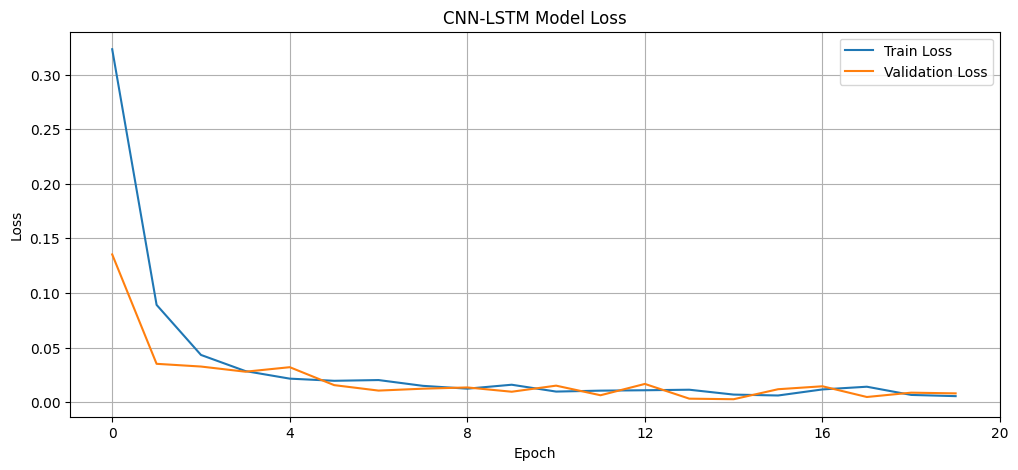

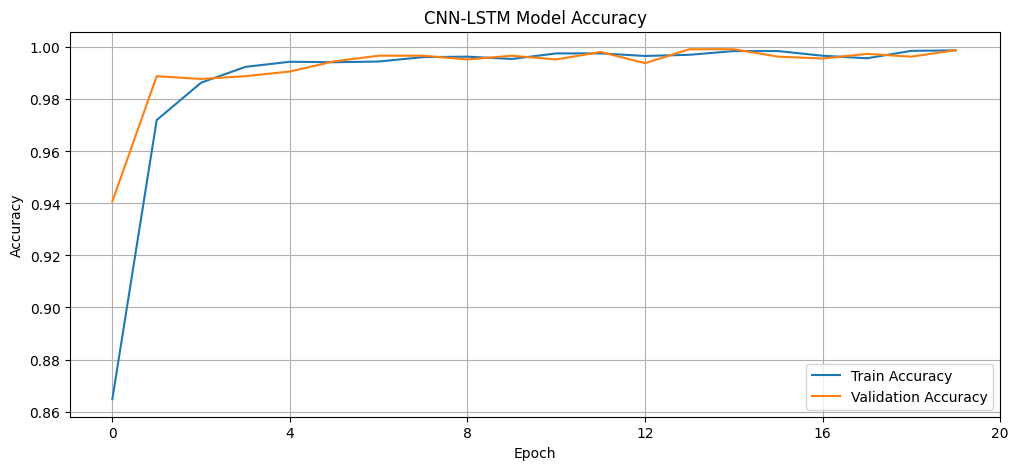

In [15]:
import matplotlib.pyplot as plt


# Vẽ biểu đồ Loss
plt.figure(figsize=(12, 5))
plt.plot(model_log.history['loss'], label='Train Loss')
plt.plot(model_log.history['val_loss'], label='Validation Loss')
plt.title('CNN-LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([0,4,8,12,16,20])  # Set custom x-axis ticks
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Vẽ biểu đồ Accuracy
plt.figure(figsize=(12, 5))
plt.plot(model_log.history['accuracy'], label='Train Accuracy')
plt.plot(model_log.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN-LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks([0,4,8,12,16,20])  # Set custom x-axis ticks
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



In [16]:
# predict for test set
pred=model.predict(testX)

88/88 [==============================] - 2s 14ms/step


In [17]:
model.save("../web/models/CNN-LSTM.keras")
# loaded_model = keras.models.load_model("../web/models/CNN-LSTM.keras")
# assert np.allclose(model.predict(testX), loaded_model.predict(testX))

In [18]:
# Threshold values predicted

for i in range(len(pred)):
    if pred[i]>0.5:
        pred[i]=1
    elif pred[i]<=0.5:
        pred[i]=0


In [19]:
# Count True predicted and wrong predicted

true=0
false=0

for i in range(len(pred)):
    if pred[i] == testY[i]:
        true+=1
    else:
        false+=1

print("correct predicted :: ", true)
print("false prediction :: ", false)

correct predicted ::  2797
false prediction ::  3


In [20]:
# Number of attack and benign data in test set

attack=0
benign=0
for i in range(len(testY)):
    if testY[i]==1:
        attack+=1
    else:
        benign+=1

print("Attack data in test set :: ", attack)
print(" Benign data in test set :: ", benign)

Attack data in test set ::  1373
 Benign data in test set ::  1427


## Confusion Matrix

In [21]:
# Takes True positive, true negative, false positive and false negative as input
# Returns Accuracy

def accuracy_function(tp,tn,fp,fn):

    accuracy = (tp+tn) / (tp+tn+fp+fn)

    return accuracy

In [22]:
# Takes True Positive and false positive
# Returns Precision

def precision_function(tp,fp):

    precision = tp / (tp+fp)

    return precision

In [23]:
#Takes True Positive and false negative
# Returns Recall

def recall_function(tp,fn):

    recall=tp / (tp+fn)

    return recall

In [24]:
def f1_function(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1


In [25]:
#Takes true values and predicted
# Returns Accuracy, precision and recall


def confusion_matrix(truth,predicted):
    
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    
    for true,pred in zip(truth,predicted):
        if true == 1:
            if pred == true:
                true_positive += 1
            elif pred != true:
                false_negative += 1

        elif true == 0:
            if pred == true:
                true_negative += 1
            elif pred != true:
                false_positive += 1
    
    accuracy=accuracy_function(true_positive, true_negative, false_positive, false_negative)
    precision=precision_function(true_positive, false_positive)
    recall=recall_function(true_positive, false_negative)
    f1 = f1_function(true_positive,false_positive,false_negative)
    
    print(f"True Positive: {true_positive}")
    print(f"True Negative: {true_negative}")
    print(f"False Positive: {false_positive}")
    print(f"False Negative: {false_negative}")
    return (accuracy,
            precision,
            recall,
            f1)

In [26]:
accuracy, precision, recall, f1= confusion_matrix(testY,pred)
print("Accuracy: {0:.4f} \nPrecision: {1:.4f} \nRecall: {2:.4f} \nF1-score: {3:.4f}".format(accuracy, precision, recall, f1))

True Positive: 1370
True Negative: 1427
False Positive: 0
False Negative: 3
Accuracy: 0.9989 
Precision: 1.0000 
Recall: 0.9978 
F1-score: 0.9989


In [27]:
# from openpyxl import Workbook, load_workbook
# from openpyxl.styles import PatternFill, Alignment

# models = {
#     "BiLSTM":2,
#     "LSTM-GAP":3,
#     "CNN":4,
#     "CNN-LSTM":5,
#     "TextCNN":6
# }

# file_name = "model_performance.xlsx"
# try:
#     wb = load_workbook(file_name)
# except FileNotFoundError:
#     # Nếu file không tồn tại, tạo một workbook mới
#     wb = Workbook()
#     sheet = wb.active
#     # Đặt màu nền cho dòng header
#     header_fill = PatternFill(start_color="92D050", end_color="92D050", fill_type="solid")

#     # Đặt tiêu đề cho các hàng và cột
#     sheet.cell(row=1, column=1).value = "Metric"
#     sheet.cell(row=1, column=1).fill = header_fill
#     metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "Correct Predict", "False Predict"]
#     for row, metric in enumerate(metrics, start=2):
#         cell = sheet.cell(row=row, column=1)
#         cell.value = metric
    
#     for col, model_name in enumerate(models, start=2):
#         cell = sheet.cell(row=1, column=col)
#         cell.value = model_name
#         cell.alignment = Alignment(horizontal="center", vertical="center")
#         cell.fill = header_fill

#     # Lưu file Excel mới
#     wb.save(file_name)
#     wb = load_workbook(file_name)

# sheet = wb.active
# sheet.column_dimensions['A'].width = 15
# model_name = "CNN-LSTM"
# col = models[model_name]
# # Ghi dữ liệu của từng mô hình vào cột tương ứng

# sheet.cell(row=2, column=col).value = f"{accuracy*100:.2f}%"
# sheet.cell(row=2, column=col).alignment = Alignment(horizontal="center", vertical="center")
# sheet.cell(row=3, column=col).value = f"{precision*100:.2f}%"
# sheet.cell(row=3, column=col).alignment = Alignment(horizontal="center", vertical="center")
# sheet.cell(row=4, column=col).value = f"{recall*100:.2f}%"
# sheet.cell(row=4, column=col).alignment = Alignment(horizontal="center", vertical="center")
# sheet.cell(row=5, column=col).value = f"{f1*100:.2f}%"
# sheet.cell(row=5, column=col).alignment = Alignment(horizontal="center", vertical="center")
# sheet.cell(row=6, column=col).value = true
# sheet.cell(row=6, column=col).alignment = Alignment(horizontal="center", vertical="center")
# sheet.cell(row=7, column=col).value = false
# sheet.cell(row=7, column=col).alignment = Alignment(horizontal="center", vertical="center")

# # Lưu file Excel sau khi thêm dữ liệu
# wb.save(file_name)
